# SCOREO / SIMULACION

A partir de esta versión de la notebook de simulacion (v3) el foco de la muestra es únicamente de "alta presencia". Se compone de los Grupos 1, 2, 3 y 4, los cuales son los grupos que contienen los marca-modelo con suficiente muestra como para cotizarlo mediante el modelo. Los autos que no entren en esta categoría los cotizaremos mediante reglas duras o pasandolos directamente al equipo de Pricing

## Librerías y configuraciones de la notebook

In [1]:
##### Librerías y modulos #######
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
from pandas.io import gbq
from datetime import datetime
import warnings
import openpyxl
import random
import os,json
import sys
sys.path.insert(0, os.path.join(os.path.dirname(os.getcwd()),'src/'))
from funcs_cotizador import *

In [2]:
####### Configuraciones de la notebook (a gusto del usuario) ##########
#pd.set_option('display.max_columns', 500)
#pd.set_option('display.width', 1000)
pd.set_option('display.float_format', lambda x: '%.4f' % x)
# warnings
warnings.filterwarnings("ignore")

In [3]:
#### Parametros de la notebook ####
path_save = '../datos/'
path_model = '../model/'

In [4]:
####### requierments ###########
#!pip install pandas-gbq

In [5]:
# Importar tabla OOT de Big Query
#df_scoreo_oot = gbq.read_gbq("SELECT * FROM `data-team-k.pricing_data.match_meli_ok` WHERE date > '2022-04-01' ", project_id="data-team-k")

In [6]:
# checkpoint upload
#df_scoreo_oot.to_csv('{}df_score_oot_checkpoint.csv'.format(path_save))

In [7]:
# checkpoint upload
df_scoreo_oot = pd.read_csv('{}df_score_oot_checkpoint.csv'.format(path_save))

In [8]:
# chequeo
print(len(df_scoreo_oot))
print(df_scoreo_oot.date.min(), df_scoreo_oot.date.max())

822639
2022-04-02 2022-04-18


## *Seteo de parametros de la notebook*

In [9]:
# Semilla para el .sample()
seed = random.randint(10,500)

## 1) Pre procesing

In [10]:
# primer tratamiento (incluye todo menos el tratamiento de outliers por contexto)
df_scoreo_oot = data_cleaning_valset(df_scoreo_oot)

Hey! 1011 were removed due to null values
Hey! 692704 were removed due to duplicate values
Hey! 1006 were removed due those 11111 or 9999 strange values
Hey! 70397 were removed due to 0km or concesioarias
Hey! 12275 were removed due to match scores under 50%
Hey! 2546 were removed due to last 15d filter
Hey! 413 were removed due to outliers globales
Hey! 7227 were removed due to categories in which we are not interested in score


In [11]:
df_scoreo_oot.shape

(35060, 12)

In [12]:
df_scoreo_oot.dtypes

runtime           datetime64[ns]
car_id                     int64
car_year                   int64
car_kms                    int64
match_marca_a             object
match_modelo_a            object
match_v1_a                object
Subseg_a                  object
Seg_a                     object
price_meli_ok            float64
car_location_1            object
match_v1_c                object
dtype: object

In [13]:
# segundo tratamiento (incluye unicamente el tratamiento de outliers por contexto)
df_scoreo_oot = data_processing_1(df_scoreo_oot,path_save)

Hey! 1188 were removed from df due to outliers under context


## 2) Chequeo de nulls

In [14]:
model_features = ['car_year','car_kms','match_marca_a','match_modelo_a','match_v1_a','Subseg_a', 'Seg_a']

In [15]:
# chequeamos que no haya nulls
# debido a que no hay ninguna imputacion de nulos en las funciones de procesamiento, si aparecen nulos aca el predict va a romper
# Es por eso que si aparecen, los dropeamos en la proxima celda
df_scoreo_oot.isnull().sum()

runtime           0
car_id            0
car_year          0
car_kms           0
match_marca_a     0
match_modelo_a    0
match_v1_a        0
Subseg_a          0
Seg_a             0
price_meli_ok     0
car_location_1    2
match_v1_c        0
dtype: int64

In [16]:
# Eliminamos los registros con nulos
for col in model_features:
    df_scoreo_oot_final = df_scoreo_oot[~df_scoreo_oot[col].isnull()]

In [17]:
df_scoreo_oot_final.shape

(33872, 12)

## 3) Seleccion muestra final (50 casos)

In [18]:
# Seleccion final de la muestra de 50 registros
df_oot_final_sample = df_scoreo_oot_final.sample(n=50, random_state=seed) 
df_oot_final_sample

,runtime,car_id,car_year,car_kms,match_marca_a,match_modelo_a,match_v1_a,Subseg_a,Seg_a,price_meli_ok,car_location_1,match_v1_c
571267,2022-04-18 13:00:37,1131164785,2019.0000,29900,RENAULT,Duster,Fase II 2.0 4x4 6MT Privilege (143cv) DISCONTINUO,Suv Compactas 4x2,SUV,3850000.0000,Córdoba,PRIVILEGE 2.0 4X4
201270,2022-04-18 10:00:28,1130037845,2010.0000,156000,CITROEN,C3,1.4 HDi SX,Gama Pequenos Hatchback,Gama Pequenos,1250000.0000,Buenos Aires Interior,1.4 I SX
604774,2022-04-18 23:00:37,1124586636,2020.0000,17000,CITROEN,C4 Lounge,1.6 HDI 6MT Feel Pack (115cv) (L16),Gama Medianos Sedan,Gama Medianos,3800000.0000,Córdoba,1.6
244768,2022-04-18 23:01:09,1127530307,2014.0000,330000,FIAT,Siena,EL 1.4 Pack Attractive Seguridad / Emotion (L10),Gama Pequenos Sedan,Gama Pequenos,1270000.0000,Capital Federal,1.4
410501,2022-04-17 21:00:36,1130854003,2013.0000,127000,FORD,KA,1.6 Fly Viral (L/08),Gama Pequenos Hatchback,Gama Pequenos,1380000.0000,Buenos Aires Interior,1.6
240572,2022-04-18 21:00:34,1125437452,2008.0000,340000,TOYOTA,Hilux,3.0 TDI C/D 4x2 SRV (171cv),Pickups Medianas-Grandes,Livianos,3500000.0000,Buenos Aires Interior,4X4
23874,2022-04-05 06:00:30,1130643684,2014.0000,133000,DODGE,Ram,2500 Laramie TD AT 4x4 C/Doble (325hp),Pickups Medianas-Grandes,Livianos,8300000.0000,Capital Federal,2500 6.7L LARAMIE 4X4
226826,2022-04-18 11:00:34,1128005694,2018.0000,33000,RENAULT,Kwid,1.0 Zen (66cv),Gama Pequenos Hatchback,Gama Pequenos,1960000.0000,Chaco,ZEN 1.0
90026,2022-04-04 07:02:16,1122380417,2012.0000,46500,AUDI,A1,1.4 TFSi S-Tronic Ambition (122cv),Gama Pequenos Premium,Gama Pequenos,3254800.0000,Capital Federal,SPORTBACK 1.4 TFSI AMBITION
203889,2022-04-18 20:01:00,1130936267,2012.0000,72500,AUDI,Q5,2.0 TFSi S-Tronic Quattro (211cv),SUV Premium,SUV,5108800.0000,Capital Federal,3.0 TFSI QUATTRO


In [19]:
# nos quedamos solo con las features que usamos en el entrenamiento del modelo para hacer el predict del modelo
X_oot = df_oot_final_sample[model_features].copy()

## 4) Scoreo de la muestra final

In [20]:
# Paso 1: Levantamos el modelo ya entrenado en la notebook anterior
import pickle
with open('{}model_catboost_v4.pickle'.format(path_model), 'rb') as f:
    model = pickle.load(f)

In [21]:
# Paso 2: predict sobre la data nueva
pred = model.predict(X_oot)

In [22]:
type(pred)

numpy.ndarray

In [23]:
len(pred)

50

## 5) Armado del output final

In [24]:
# Precio promedio en MELI
grouped = df_scoreo_oot_final.groupby(['match_marca_a','match_modelo_a','match_v1_a','car_year'], as_index=False)['price_meli_ok'].mean()
grouped.rename(columns={'price_meli_ok':'precio_prom_meli'},inplace=True)
df_oot_final_sample = df_oot_final_sample.merge(grouped, how='inner', on=['match_marca_a','match_modelo_a','match_v1_a','car_year'])

In [25]:
df_oot_final_sample['precio_estimado'] = pred

In [26]:
df_oot_final_sample['precio_estimado'] = df_oot_final_sample['precio_estimado'].astype('int64')
df_oot_final_sample['precio_prom_meli'] = df_oot_final_sample['precio_prom_meli'].astype('int64')

In [27]:
from datetime import datetime
df_oot_final_sample['fecha_simulacion'] = datetime.today().strftime('%Y-%m-%d')

In [28]:
df_oot_final_sample.columns

Index(['runtime', 'car_id', 'car_year', 'car_kms', 'match_marca_a',
       'match_modelo_a', 'match_v1_a', 'Subseg_a', 'Seg_a', 'price_meli_ok',
       'car_location_1', 'match_v1_c', 'precio_prom_meli', 'precio_estimado',
       'fecha_simulacion'],
      dtype='object')

In [29]:
# Ordenamos las columnas de forma prolija
df_oot_final_sample = df_oot_final_sample[['car_id','match_marca_a','match_modelo_a','match_v1_a','match_v1_c'
                                                         ,'car_year','car_kms','Seg_a','Subseg_a','car_location_1'
                                                         ,'precio_estimado','precio_prom_meli','price_meli_ok','fecha_simulacion']]
df_oot_final_sample.rename(columns={'price_meli_ok':'precio_real'},inplace=True)
df_oot_final_sample['precio_real'] = df_oot_final_sample['precio_real'].astype('int64')

In [30]:
# chequeo
df_oot_final_sample.head()

,car_id,match_marca_a,match_modelo_a,match_v1_a,match_v1_c,car_year,car_kms,Seg_a,Subseg_a,car_location_1,precio_estimado,precio_prom_meli,precio_real,fecha_simulacion
0,1131164785,RENAULT,Duster,Fase II 2.0 4x4 6MT Privilege (143cv) DISCONTINUO,PRIVILEGE 2.0 4X4,2019.0000,29900,SUV,Suv Compactas 4x2,Córdoba,3454187,3833333,3850000,2022-04-19
1,1130037845,CITROEN,C3,1.4 HDi SX,1.4 I SX,2010.0000,156000,Gama Pequenos,Gama Pequenos Hatchback,Buenos Aires Interior,1020229,1107894,1250000,2022-04-19
2,1124586636,CITROEN,C4 Lounge,1.6 HDI 6MT Feel Pack (115cv) (L16),1.6,2020.0000,17000,Gama Medianos,Gama Medianos Sedan,Córdoba,3719736,3695000,3800000,2022-04-19
3,1127530307,FIAT,Siena,EL 1.4 Pack Attractive Seguridad / Emotion (L10),1.4,2014.0000,330000,Gama Pequenos,Gama Pequenos Sedan,Capital Federal,867155,1249666,1270000,2022-04-19
4,1130854003,FORD,KA,1.6 Fly Viral (L/08),1.6,2013.0000,127000,Gama Pequenos,Gama Pequenos Hatchback,Buenos Aires Interior,1094154,1199578,1380000,2022-04-19


In [31]:
# chequeo
df_oot_final_sample.precio_estimado.describe()

count        50.0000
mean    2637635.8400
std     1741511.9432
min      762054.0000
25%     1467566.7500
50%     2055974.0000
75%     3180109.2500
max     7572473.0000
Name: precio_estimado, dtype: float64

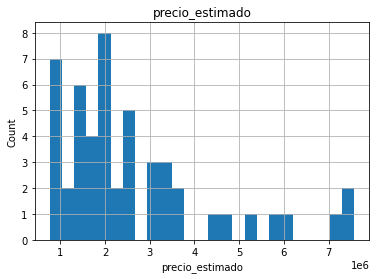

In [32]:
# chequeo
# Distribucion del target
df_oot_final_sample['precio_estimado'].hist(bins=25)
plt.xlabel('precio_estimado')
plt.ylabel("Count")
plt.title('precio_estimado')
plt.show()

In [33]:
df_oot_final_sample.shape

(50, 14)

**Chequeamos R2 y RMSE para la simulacion**

In [34]:
print('Test set evaluation:\n_____________________________________')
print_evaluate(df_oot_final_sample.precio_real, df_oot_final_sample.precio_estimado)

Test set evaluation:
_____________________________________
MAE: 741376.76
MAPE: 29.04985081512983
MEDAPE: 14.854097222222224
MSE: 1712507451362.72
RMSE: 1308628.0798464932
R2 Square 0.47000547749375376
__________________________________


In [36]:
df_oot_final_sample

,car_id,match_marca_a,match_modelo_a,match_v1_a,match_v1_c,car_year,car_kms,Seg_a,Subseg_a,car_location_1,precio_estimado,precio_prom_meli,precio_real,fecha_simulacion
0,1131164785,RENAULT,Duster,Fase II 2.0 4x4 6MT Privilege (143cv) DISCONTINUO,PRIVILEGE 2.0 4X4,2019.0000,29900,SUV,Suv Compactas 4x2,Córdoba,3454187,3833333,3850000,2022-04-19
1,1130037845,CITROEN,C3,1.4 HDi SX,1.4 I SX,2010.0000,156000,Gama Pequenos,Gama Pequenos Hatchback,Buenos Aires Interior,1020229,1107894,1250000,2022-04-19
2,1124586636,CITROEN,C4 Lounge,1.6 HDI 6MT Feel Pack (115cv) (L16),1.6,2020.0000,17000,Gama Medianos,Gama Medianos Sedan,Córdoba,3719736,3695000,3800000,2022-04-19
3,1127530307,FIAT,Siena,EL 1.4 Pack Attractive Seguridad / Emotion (L10),1.4,2014.0000,330000,Gama Pequenos,Gama Pequenos Sedan,Capital Federal,867155,1249666,1270000,2022-04-19
4,1130854003,FORD,KA,1.6 Fly Viral (L/08),1.6,2013.0000,127000,Gama Pequenos,Gama Pequenos Hatchback,Buenos Aires Interior,1094154,1199578,1380000,2022-04-19
5,1125437452,TOYOTA,Hilux,3.0 TDI C/D 4x2 SRV (171cv),4X4,2008.0000,340000,Livianos,Pickups Medianas-Grandes,Buenos Aires Interior,3035584,3456925,3500000,2022-04-19
6,1130643684,DODGE,Ram,2500 Laramie TD AT 4x4 C/Doble (325hp),2500 6.7L LARAMIE 4X4,2014.0000,133000,Livianos,Pickups Medianas-Grandes,Capital Federal,6172321,8300000,8300000,2022-04-19
7,1128005694,RENAULT,Kwid,1.0 Zen (66cv),ZEN 1.0,2018.0000,33000,Gama Pequenos,Gama Pequenos Hatchback,Chaco,2023200,1887300,1960000,2022-04-19
8,1122380417,AUDI,A1,1.4 TFSi S-Tronic Ambition (122cv),SPORTBACK 1.4 TFSI AMBITION,2012.0000,46500,Gama Pequenos,Gama Pequenos Premium,Capital Federal,3263029,2922820,3254800,2022-04-19
9,1130936267,AUDI,Q5,2.0 TFSi S-Tronic Quattro (211cv),3.0 TFSI QUATTRO,2012.0000,72500,SUV,SUV Premium,Capital Federal,4665382,4244606,5108800,2022-04-19


**Guardamos la simulacion**

In [37]:
# Guardamos el rdo final
current_date = datetime.today().strftime('%Y-%m-%d')
df_scoreo_oot_final_sample.to_excel(f'simulacion_{current_date}.xlsx')
# en esta última linea, poner el path que querramos para guardar el output